## `Speculator`: NMF-based SFH with burst.

`speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`), spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor
from scipy.stats import norm

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index

(10 params)

### Train emulator step-by-step
In reality, the emulator is trained using using `~/Research/popsed/script/emulator/train_emulator.py`)

In [4]:
name = 'NMF_ZH'

In [6]:
params = np.concatenate([np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.v0.2.theta_unt.seed{i+1}.npy')
                         for i in range(0, 1)])
params = params[:, 1:] # exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 300000


In [7]:
i_bin = 2

wave_bin = [ 
        (wave >= 1000) & (wave < 2000), 
        (wave >= 2000) & (wave < 3600), 
        (wave >= 3600) & (wave < 5500), 
        (wave >= 5500) & (wave < 7410), 
        (wave >= 7410) & (wave < 60000)
        ][i_bin]
str_wbin = [
        '.w1000_2000', 
        '.w2000_3600', 
        '.w3600_5500', 
        '.w5500_7410', 
        '.w7410_60000' 
        ][i_bin]

In [10]:
speculator = Speculator(name=f'{name}_{i_bin}', model='NMF_ZH', n_parameters=11,
                        pca_filename=f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.pca_trained{str_wbin}.pkl',
                        hidden_size=[256, 256, 256, 256, 256])

In [13]:
fspecs = [f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.v0.2.log10spectrum.seed{i+1}{str_wbin}.npy'
          for i in range(int(0), int(1))]
pca_coeff = []
for file in fspecs:
    pca_coeff.append(speculator.pca.PCA.transform(
        speculator.pca.logspec_scaler.transform(np.load(file, mmap_mode='r'))))
pca_coeff = np.concatenate(pca_coeff)
print('PCA coeff shape=', pca_coeff.shape)

PCA coeff shape= (300000, 50)


In [15]:
batch_size = 10000

In [16]:
speculator.load_data(pca_coeff, params,
                     params_name=['beta1_sfh', 'beta2_sfh', 'beta3_sfh', 'beta4_sfh',
                                  'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                                  'dust1', 'dust2', 'dust_index', 'redshift'],
                     val_frac=0.1, batch_size=batch_size,
                     wave_rest=torch.Tensor(wave[wave_bin]),
                     wave_obs=torch.Tensor(wave[wave_bin]))

In [9]:
logspec = np.concatenate([np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.v0.2.log10spectrum.seed{i+1}{str_wbin}.npy')
                           for i in range(0, 1)])
logspec = logspec.astype('float32')
# logspec = interp_nan(logspec)
# print(logspec.shape)
# # Very large... and slow

In [ ]:
# zero_flag = (np.mean(logspec, axis=1) < -40)

# logspec = logspec[~zero_flag]
# params = params[~zero_flag]
# pca_coeff = np.load('./train_sed/fsps.pca_coeffs.npy')[~zero_flag]
# # This zero_flag is SUPER IMPORTANT!!!

In [12]:
outputs = _speculator.network(torch.Tensor(params).to('cuda'))
outputs = _speculator.pca.inverse_transform(
    _speculator.pca_scaler.inverse_transform(outputs), device=_speculator.device)
outputs = _speculator.pca.logspec_scaler.inverse_transform(outputs, device='cuda')

labels = _speculator.pca.inverse_transform(torch.Tensor(pca_coeff).to('cuda'), device='cuda')
labels = _speculator.pca.logspec_scaler.inverse_transform(labels, device='cuda')

In [13]:
params[219]

array([0.30093479, 0.67253883, 0.49785728, 0.33456504, 3.48838738,
       0.24142903, 1.30242459, 1.35514058, 0.12777126, 1.4449618 ])

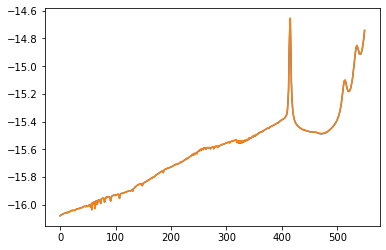

In [14]:
plt.plot(outputs[29].cpu().detach().numpy())
plt.plot(labels[29].cpu().detach().numpy())

In [86]:
from torch.nn import MSELoss

In [87]:
# _specs = speculator.predict_spec(torch.Tensor(params[val_ind]).to('cuda')).cpu().detach().numpy()
# _specs = _speculator.predict_spec(torch.Tensor(params).to('cuda')).cpu().detach().numpy()

In [15]:
outputs = _speculator.network(torch.Tensor(params).to('cuda'))
outputs = _speculator.pca.inverse_transform(
    _speculator.pca_scaler.inverse_transform(outputs), device=_speculator.device)
_logspecs = _speculator.pca.logspec_scaler.inverse_transform(outputs, device='cuda')
_logspecs = _logspecs.detach().cpu().numpy()

labels = _speculator.pca.inverse_transform(torch.Tensor(pca_coeff).to('cuda'), device='cuda')
# labels = _speculator.pca.logspec_scaler.inverse_transform(labels, device='cuda')

In [89]:
MSELoss()(torch.Tensor(_logspecs).to('cuda'), torch.Tensor(logspec).to('cuda'))

RuntimeError: CUDA out of memory. Tried to allocate 808.00 MiB (GPU 0; 15.90 GiB total capacity; 14.44 GiB already allocated; 425.75 MiB free; 14.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
MSELoss()(outputs, labels)

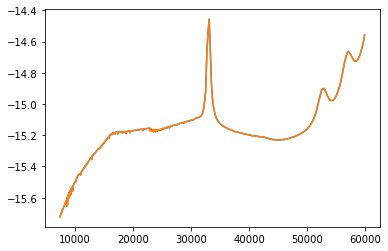

In [16]:
plt.plot(wave[wave_bin], _logspecs[122])
# plt.plot(wave[wave_bin], logspec[val_ind][529])
plt.plot(wave[wave_bin], logspec[122])

### Validate emulators

In [4]:
params = np.load(f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.theta_unt.seedtest.npy')
params = params[:, 1:] # exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 100000


In [169]:
i_bin = 3

wave_bin = [ 
        (wave >= 1000) & (wave < 2000), 
        (wave >= 2000) & (wave < 3600), 
        (wave >= 3600) & (wave < 5500), 
        (wave >= 5500) & (wave < 7410), 
        (wave >= 7410) & (wave < 60000)
        ][i_bin]
str_wbin = [
        '.w1000_2000', 
        '.w2000_3600', 
        '.w3600_5500', 
        '.w5500_7410', 
        '.w7410_60000' 
        ][i_bin]

In [170]:
fspecs = [f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.log10spectrum.seedtest{str_wbin}.npy']
logspec = np.load(fspecs[0])
logspec = logspec.astype('float32')

In [176]:
wave = wave[wave >= 2000]
wave_bin = wave_bin[wave >= 2000]

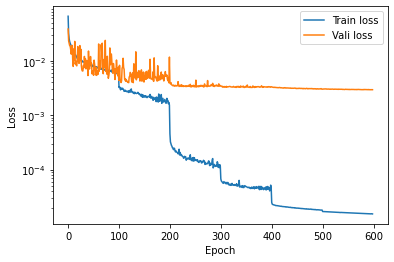

In [173]:
## Load the NN emulator `speculator`
with open(f'./speculator_best_loss_model_NMF.emu_{i_bin}.pkl', 'rb') as f:
    _speculator = pickle.load(f)
_speculator.plot_loss()

In [177]:
outputs = _speculator.network(torch.Tensor(params).to('cuda'))
outputs = _speculator.pca.inverse_transform(
    _speculator.pca_scaler.inverse_transform(outputs), device=_speculator.device)
_logspecs = _speculator.pca.logspec_scaler.inverse_transform(outputs, device='cuda')
_logspecs = _logspecs.detach().cpu().numpy()

# labels = _speculator.pca.inverse_transform(torch.Tensor(pca_coeff).to('cuda'), device='cuda')
# labels = _speculator.pca.logspec_scaler.inverse_transform(labels, device='cuda')

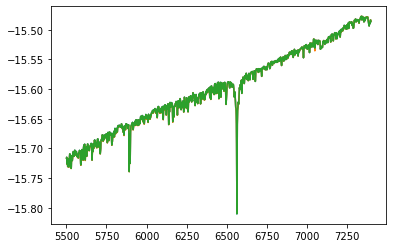

In [183]:
ind = 15
plt.plot(wave[wave_bin], _logspecs[ind])
plt.plot(wave[wave_bin], logspec[ind])
plt.plot(wave[wave_bin], np.log10(official_pred)[ind])

In [191]:
official_pred = _speculator.predict_spec(
    torch.Tensor(params[:20]).to('cuda'), redshift=torch.ones(len(params[:20]), 1).to('cuda') * 0.1,
).cpu().detach().numpy()

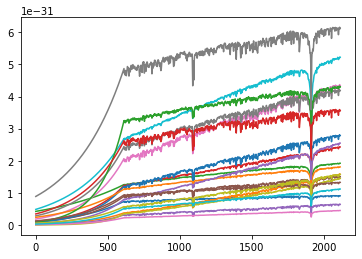

In [192]:
plt.plot(official_pred.T)

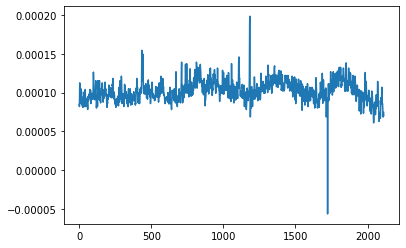

In [179]:
# plt.plot(np.nanmedian(np.log10(_specs) - logspec[val_ind], axis=0))
# plt.plot(np.nanmedian(np.log10(_specs) - logspec, axis=0))
plt.plot(np.nanmedian(_logspecs - logspec, axis=0))

In [28]:
# diff = (10**logspec[val_ind] - _specs) / 10**logspec[val_ind] * 100
# diff = np.abs(10**logspec - _specs) / 10**logspec * 100
diff = np.abs(10**logspec - 10**_logspecs) / 10**logspec# * 100
# diff = (10**logspec - _specs) / 10**logspec* 100
# diff = (logspec[val_ind] - np.log10(_specs)) / logspec[val_ind] * 100

Text(0.5, 0, 'Wavelength [nm]')

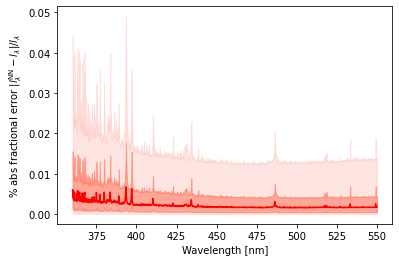

In [29]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% abs fractional error $|l_{\lambda}^{\mathrm{NN}} - l_{\lambda}|/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.xscale('log')
# plt.ylim(0, 0.05)

In [30]:
diff = (10**logspec - 10**_logspecs) / 10**logspec* 100

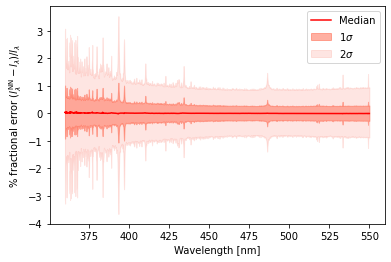

In [31]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

# plt.ylim(-5, 5)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

# plt.xlim(200, 1100)

### Combine emulators

In [5]:
params = np.load(f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.theta_unt.seedtest.npy')
params = params[:, 1:] # exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
wave = wave[wave > 2000]
print('Number of samples:', params.shape[0])

Number of samples: 100000


In [6]:
from popsed.speculator import SuperSpeculator

In [17]:
superspec = SuperSpeculator(speculators_dir=[
    f'./speculator_best_loss_model_NMF.emu_{i_bin}.pkl' for i_bin in range(1, 5)], 
                            str_wbin=[
        '.w2000_3600', 
        '.w3600_5500', 
        '.w5500_7410', 
        '.w7410_60000' 
        ], wavelength=wave)

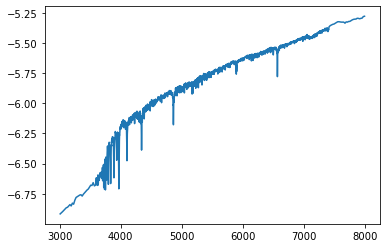

In [18]:
specs = torch.log10(superspec.predict_spec(params[:10], 
                       log_stellar_mass=torch.ones(10, 1).to('cuda') * 10, 
                       redshift=torch.zeros(10, 1).to('cuda') * 0.01))
flag = (superspec.wavelength < 8000) & (superspec.wavelength > 3000)
specs = specs[:, flag].cpu().detach().numpy()
plt.plot(superspec.wavelength[flag].cpu().numpy(), specs[5])

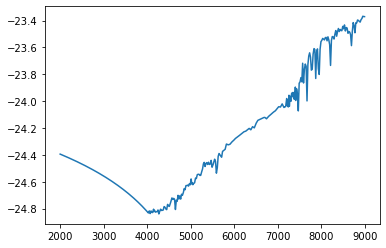

In [32]:
specs = torch.log10(superspec.predict_spec(params[:10], 
                       log_stellar_mass=torch.ones(10, 1).to('cuda') * 10, 
                       redshift=torch.ones(10, 1).to('cuda') * 1))
# flag = (superspec.wavelength < 8000) & (superspec.wavelength > 3000)
# specs = specs[:, flag].cpu().detach().numpy()
# plt.plot(superspec.wavelength[flag].cpu().numpy(), specs[5])

flag = (superspec.wavelength < 9000)
specs = specs[:, flag].cpu().detach().numpy()
plt.plot(superspec.wavelength[flag].cpu().numpy(), specs[5])